In [2]:
import os

import gdal
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

import csv
import glob

import cv2

In [3]:
home = os.environ['HOME']
KENYA_IMAGES_PATH = os.path.join(os.path.sep, home, 'cs325b', 'roadtype', 'kenya_road_images')
PERU_IMAGES_PATH = os.path.join(os.path.sep, home, 'cs325b', 'roadtype', 'peru_road_images')
ROADTYPE_PATH = os.path.join(os.path.sep, home, 'cs325b', 'roadtype')

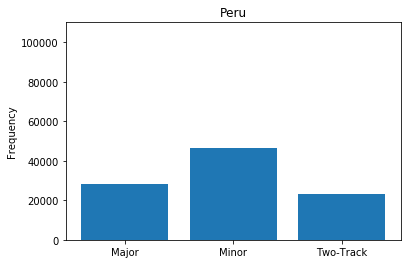

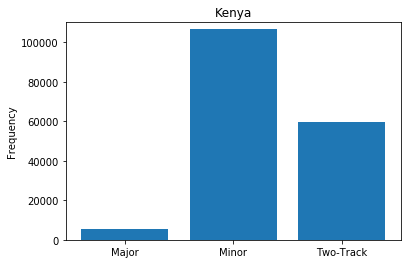

In [3]:
p_freq = [28194, 46259, 22948]
k_freq = [5666, 106679, 59820]

plt.bar(['Major', 'Minor', 'Two-Track'], p_freq)
plt.title('Peru')
plt.ylim(0, 110000)
plt.ylabel('Frequency')
plt.show()

plt.title('Kenya')
plt.bar(['Major', 'Minor', 'Two-Track'], k_freq)
plt.ylim(0, 110000)
plt.ylabel('Frequency')
plt.show()


TIF Size (W, H):  224 224
(3, 224, 224)


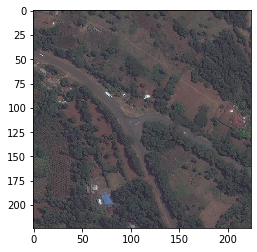

In [5]:
# test = os.path.join(KENYA_IMAGES_PATH, 'kenya_1000x1000_100177_422264.tif')
test = os.path.join(os.path.sep, home, 'cs325b', 'test_images', 'kenya_road_images', 'kenya_1000x1000_10008_444523_resized.tif')

def read(tif_path):
    gdal_dataset = gdal.Open(tif_path)
    # x_size and y_size and the width and height of the entire tif in pixels
    x_size, y_size = gdal_dataset.RasterXSize, gdal_dataset.RasterYSize
    print("TIF Size (W, H): ", x_size, y_size)
    W = x_size
    H = y_size
    # Mid point minus half the width and height we want to read will give us our top left corner
    if W > x_size:
        raise Exception("Requested width exceeds tif width.")
    if H > y_size:
        raise Exception("Requested height exceeds tif height.")
    gdal_result = gdal_dataset.ReadAsArray((x_size - W)//2, (y_size - H)//2, W, H)
    # If a tif file has only 1 band, then the band dimension will be removed.
    if len(gdal_result.shape) == 2:
        gdal_result = np.reshape(gdal_result, [1] + list(gdal_result.shape))
    # gdal_result is a rank 3 tensor as follows (bands, height, width)
    print(gdal_result.shape)
    return np.transpose(gdal_result, (1, 2, 0))

plt.imshow(read(test))
plt.show()
    

In [6]:
kenya_dbf_csv = os.path.join(os.path.sep, home, 'cs325b', 'extra_data', 'kenya_dbf.csv')
peru_dbf_csv = os.path.join(os.path.sep, home, 'cs325b', 'extra_data', 'peru_dbf.csv')

def dbf_csv_read(file):
    dict_roadtypes = {}
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            elif row[2] == 'major' or row[2] == 'minor' or row[2] == 'two-track':
#                 dict_roadtypes[int(row[0])] = {'roadtype': row[2]}
                dict_roadtypes[float(line_count)] = {'roadtype': row[2], 'name': row[1]}
    #             print(f'\t{row[0]}, {row[1]}, {row[2]}.')
                line_count += 1
        print(f'Processed {line_count - 1} lines.')
    return dict_roadtypes
                      
kenya_dict = dbf_csv_read(kenya_dbf_csv)
peru_dict = dbf_csv_read(peru_dbf_csv)

Column names are ﻿osm_id, name, highway
Processed 172165 lines.
Column names are ﻿osm_id, name, highway
Processed 97401 lines.


In [7]:
kenya_bbox_csv = os.path.join(os.path.sep, ROADTYPE_PATH, 'kenya_roads_bbox_300m.csv')
peru_bbox_csv = os.path.join(os.path.sep, ROADTYPE_PATH, 'peru_roads_bbox_300m.csv')

kenya_id_dict = {}
peru_id_dict = {}

def kenya_bbox_csv_read(file, dict_roadtypes):
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
                dict_roadtypes[float(row[1])]['lat'] = float(row[4])
                dict_roadtypes[float(row[1])]['lon'] = float(row[3])
                if not float(row[2]) in kenya_id_dict.keys():
                    kenya_id_dict[float(row[2])] = float(row[1])
    #             print(f'\t{row[0]}, {row[1]}, {row[2]}.')
                line_count += 1
        print(f'Processed {line_count - 1} lines.')
    return dict_roadtypes

def peru_bbox_csv_read(file, dict_roadtypes):
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            elif float(row[2]) % 2 == 0:
                dict_roadtypes[float(row[2]) / 2]['lat'] = (float(row[4]) + float(row[6])) / 2
                dict_roadtypes[float(row[2]) / 2]['lon'] = float(row[3])
                peru_id_dict[float(row[1])] = float(row[2]) / 2
    #             print(f'\t{row[0]}, {row[1]}, {row[2]}.')
                line_count += 1
        print(f'Processed {line_count - 1} lines.')
    return dict_roadtypes
                      
kenya_dict = kenya_bbox_csv_read(kenya_bbox_csv, kenya_dict)
peru_dict = peru_bbox_csv_read(peru_bbox_csv, peru_dict)

Column names are , index, id, lon, lat, minLat, maxLat, minLon, maxLon
Processed 172165 lines.
Column names are system:index, id, index, lon, maxlat, maxlon, minlat, minlon, .geo
Processed 97401 lines.


In [8]:
kenya_major_lat = []
kenya_major_lon = []
kenya_minor_lat = []
kenya_minor_lon = []
kenya_two_track_lat = []
kenya_two_track_lon = []

peru_major_lat = []
peru_major_lon = []
peru_minor_lat = []
peru_minor_lon = []
peru_two_track_lat = []
peru_two_track_lon = []


for value in kenya_dict.items():
    if value[1]['roadtype'] == 'major':
        kenya_major_lat.append(value[1]['lat'])
        kenya_major_lon.append(value[1]['lon'])
    elif value[1]['roadtype'] == 'minor':
        kenya_minor_lat.append(value[1]['lat'])
        kenya_minor_lon.append(value[1]['lon'])
    elif value[1]['roadtype'] == 'two-track':
        kenya_two_track_lat.append(value[1]['lat'])
        kenya_two_track_lon.append(value[1]['lon'])
        
for value in peru_dict.items():
    if value[1]['roadtype'] == 'major':
        peru_major_lat.append(value[1]['lat'])
        peru_major_lon.append(value[1]['lon'])
    elif value[1]['roadtype'] == 'minor':
        peru_minor_lat.append(value[1]['lat'])
        peru_minor_lon.append(value[1]['lon'])
    elif value[1]['roadtype'] == 'two-track':
        peru_two_track_lat.append(value[1]['lat'])
        peru_two_track_lon.append(value[1]['lon'])


/home/BenChoi/miniconda3/envs/cs325b/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
/home/BenChoi/miniconda3/envs/cs325b/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/BenChoi/miniconda3/envs/cs325b/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/home/BenChoi/miniconda3/envs/cs325b/lib/python3.7/site-packages/ip

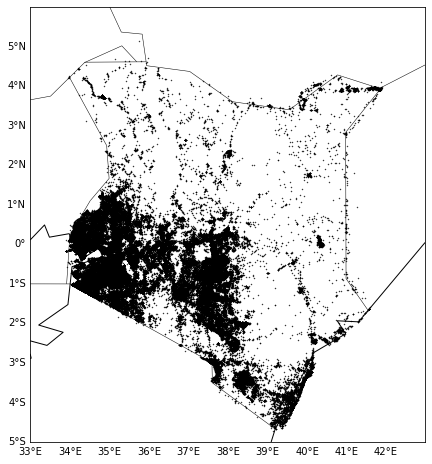

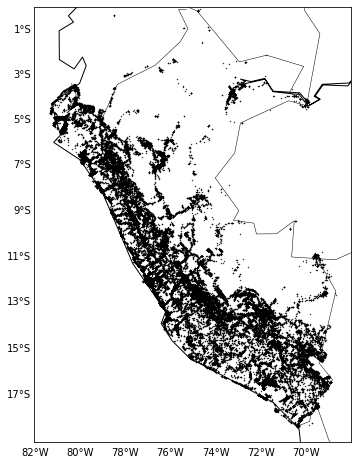

In [70]:
#KENYA, 33, 43, -5, 6

fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='mill',llcrnrlat=-5,urcrnrlat=6,\
                llcrnrlon=33,urcrnrlon=43,resolution='c')
 
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(int(-5),int(6),1),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(int(33),int(43),1),labels=[0,0,0,1], linewidth=0.0)
x,y = m(kenya_major_lon, kenya_major_lat)
x1,y1 = m(kenya_minor_lon, kenya_minor_lat)
x2,y2 = m(kenya_two_track_lon, kenya_two_track_lat)

axs = plt.subplot(111)
m.plot(x, y, 'ok', markersize=0.4, label='major')
axs.plot(x1, y1, 'ok', markersize=0.4, label='minor')
axs.plot(x2, y2, 'ok', markersize=0.4, label='two-track')
# axs.legend(markerscale=5)

#PERU, -82, -68, -19, 0

fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='mill',llcrnrlat=-19,urcrnrlat=0,\
                llcrnrlon=-82,urcrnrlon=-68,resolution='c')
 
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(int(-19),int(0),2),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(int(-82),int(-68),2),labels=[0,0,0,1], linewidth=0.0)
x,y = m(peru_major_lon, peru_major_lat)
x1,y1 = m(peru_minor_lon, peru_minor_lat)
x2,y2 = m(peru_two_track_lon, peru_two_track_lat)

axs = plt.subplot(111)
m.plot(x, y, 'ok', markersize=0.4, label='major')
axs.plot(x1, y1, 'ok', markersize=0.4, label='minor')
axs.plot(x2, y2, 'ok', markersize=0.4, label='two-track')
# axs.legend(markerscale=5)

plt.show()

In [10]:
arr = []
i=0
count = 0
for file in glob.glob(os.path.join(os.path.sep, KENYA_IMAGES_PATH, '*.tif')):
    if i % 20 == 0:
        if kenya_dict[kenya_id_dict[float(file.split('_')[-1].split('.')[0])]]['roadtype'] == 'major':
            cv_obj = cv2.imread(file)
            if not cv_obj is None:
                row = np.mean(np.array(cv_obj), axis=(0, 1))
                row = np.append(row, float(kenya_dict[kenya_id_dict[float(file.split('_')[-1].split('.')[0])]]['length']))
                if row.shape[0] == 4:
                    arr.append(row)
                count += 1
    i+=1
    if count > 99:
        break
k_major_arr = np.array(arr)
print(k_major_arr.shape)
print(np.mean(k_major_arr, axis=0))

(100, 4)
[121.05165483 125.24940691 126.43612185   0.72929607]


In [11]:
arr = []
i=0
count = 0
for file in glob.glob(os.path.join(os.path.sep, KENYA_IMAGES_PATH, '*.tif')):
    if i % 20 == 0:
        if kenya_dict[kenya_id_dict[float(file.split('_')[-1].split('.')[0])]]['roadtype'] == 'minor':
            cv_obj = cv2.imread(file)
            if not cv_obj is None:
                row = np.mean(np.array(cv_obj), axis=(0, 1))
                row = np.append(row, float(kenya_dict[kenya_id_dict[float(file.split('_')[-1].split('.')[0])]]['length']))
                if row.shape[0] == 4:
                    arr.append(row)
                count += 1
        #print(np.array(cv2.imread(file)).shape)
    i+=1
    if count > 99:
        break
k_minor_arr = np.array(arr)
print(k_minor_arr.shape)
print(np.mean(k_minor_arr, axis=0))

(100, 4)
[91.35573862 96.95091155 95.48994764  0.80671355]


In [12]:
arr = []
i=0
count = 0
for file in glob.glob(os.path.join(os.path.sep, KENYA_IMAGES_PATH, '*.tif')):
    if i % 20 == 0:
        if kenya_dict[kenya_id_dict[float(file.split('_')[-1].split('.')[0])]]['roadtype'] == 'two-track':
            cv_obj = cv2.imread(file)
            if not cv_obj is None:
                row = np.mean(np.array(cv_obj), axis=(0, 1))
                row = np.append(row, float(kenya_dict[kenya_id_dict[float(file.split('_')[-1].split('.')[0])]]['length']))
                if row.shape[0] == 4:
                    arr.append(row)
                count += 1
        #print(np.array(cv2.imread(file)).shape)
    i+=1
    if count > 99:
        break
k_two_arr = np.array(arr)
print(k_two_arr.shape)
print(np.mean(k_two_arr, axis=0))

(100, 4)
[ 99.99678533 105.54118241 103.33675294   0.90938949]


In [13]:
arr = []
i=0
count = 0
for file in glob.glob(os.path.join(os.path.sep, PERU_IMAGES_PATH, '*.tif')):
    if i % 20 == 0:
        if peru_dict[peru_id_dict[float(file.split('_')[-1].split('.')[0])]]['roadtype'] == 'major':
            cv_obj = cv2.imread(file)
            if not cv_obj is None:
                row = np.mean(np.array(cv_obj), axis=(0, 1))
                row = np.append(row, float(peru_dict[peru_id_dict[float(file.split('_')[-1].split('.')[0])]]['length']))
                if row.shape[0] == 4:
                    arr.append(row)
                count += 1
        #print(np.array(cv2.imread(file)).shape)
    i+=1
    if count > 99:
        break
p_major_arr = np.array(arr)
print(p_major_arr.shape)
print(np.mean(p_major_arr, axis=0))

(100, 4)
[124.77377765 126.27055715 129.42241586   0.50458566]


In [14]:
arr = []
i=0
count = 0
for file in glob.glob(os.path.join(os.path.sep, PERU_IMAGES_PATH, '*.tif')):
    if i % 20 == 0:
        if peru_dict[peru_id_dict[float(file.split('_')[-1].split('.')[0])]]['roadtype'] == 'minor':
            cv_obj = cv2.imread(file)
            if not cv_obj is None:
                row = np.mean(np.array(cv_obj), axis=(0, 1))
                row = np.append(row, float(peru_dict[peru_id_dict[float(file.split('_')[-1].split('.')[0])]]['length']))
                if row.shape[0] == 4:
                    arr.append(row)
                count += 1
        #print(np.array(cv2.imread(file)).shape)
    i+=1
    if count > 99:
        break
p_minor_arr = np.array(arr)
print(p_minor_arr.shape)
print(np.mean(p_minor_arr, axis=0))

(100, 4)
[124.41995174 129.24198186 131.74373928   0.25441643]


In [15]:
arr = []
i=0
count = 0
for file in glob.glob(os.path.join(os.path.sep, PERU_IMAGES_PATH, '*.tif')):
    if i % 20 == 0:
        if peru_dict[peru_id_dict[float(file.split('_')[-1].split('.')[0])]]['roadtype'] == 'two-track':
            cv_obj = cv2.imread(file)
            if not cv_obj is None:
                row = np.mean(np.array(cv_obj), axis=(0, 1))
                row = np.append(row, float(peru_dict[peru_id_dict[float(file.split('_')[-1].split('.')[0])]]['length']))
                if row.shape[0] == 4:
                    arr.append(row)
                count += 1
        #print(np.array(cv2.imread(file)).shape)
    i+=1
    if count > 99:
        break
p_two_arr = np.array(arr)
print(p_two_arr.shape)
print(np.mean(p_two_arr, axis=0))

(100, 4)
[134.3609289  135.90138625 138.17164154   0.34555761]


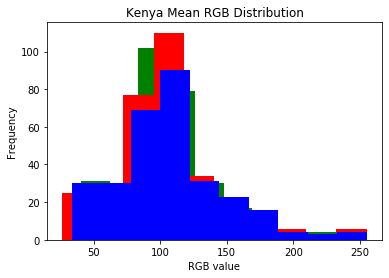

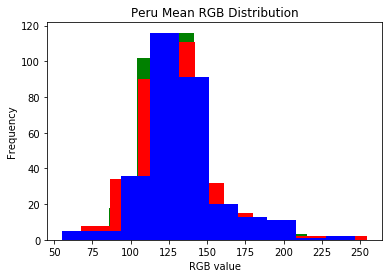

In [78]:
np.concatenate((k_major_arr, k_minor_arr, k_two_arr))
plt.hist(np.concatenate((k_major_arr, k_minor_arr, k_two_arr))[:, 0], zorder=2, color='red')
plt.hist(np.concatenate((k_major_arr, k_minor_arr, k_two_arr))[:, 1], zorder=1, color='green')
plt.hist(np.concatenate((k_major_arr, k_minor_arr, k_two_arr))[:, 2], zorder=3, color='blue')

plt.title('Kenya Mean RGB Distribution')
plt.ylabel('Frequency')
plt.xlabel('RGB value')

plt.show()


np.concatenate((p_major_arr, p_minor_arr, p_two_arr))
plt.hist(np.concatenate((p_major_arr, p_minor_arr, p_two_arr))[:, 0], zorder=2, color='red')
plt.hist(np.concatenate((p_major_arr, p_minor_arr, p_two_arr))[:, 1], zorder=1, color='green')
plt.hist(np.concatenate((p_major_arr, p_minor_arr, p_two_arr))[:, 2], zorder=3, color='blue')

plt.title('Peru Mean RGB Distribution')
plt.ylabel('Frequency')
plt.xlabel('RGB value')

plt.show()


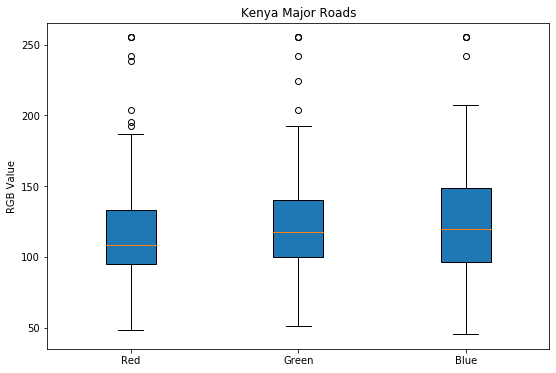

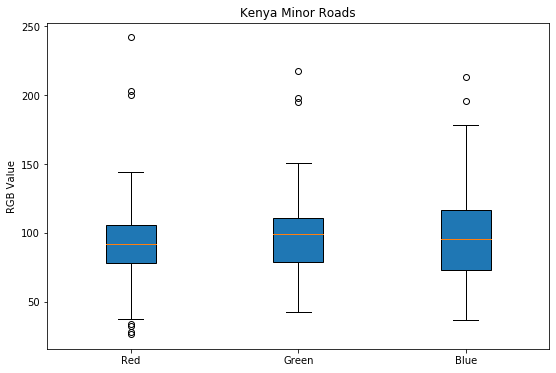

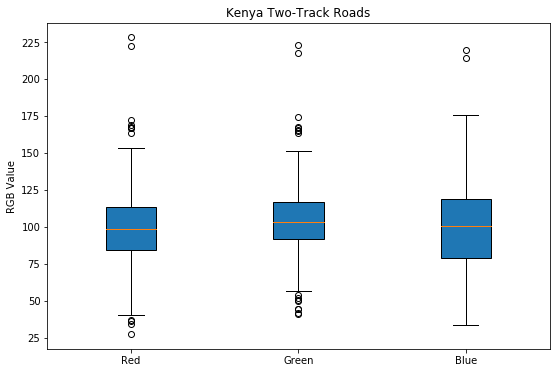

In [14]:
# fig = plt.figure(1, figsize=(9, 6))
# ax = fig.add_subplot(111)
# bp = ax.boxplot([k_major_arr[:, 0], k_major_arr[:, 1], k_major_arr[:, 2]], patch_artist=True)

# ax.set_ylabel('RGB Value')
# ax.set_xticklabels(['Red', 'Green', 'Blue'])

# ax.set_title('Kenya Major Roads')

# plt.show()

# fig = plt.figure(1, figsize=(9, 6))
# ax = fig.add_subplot(111)
# ax.boxplot([k_minor_arr[:, 0], k_minor_arr[:, 1], k_minor_arr[:, 2]], patch_artist=True)

# ax.set_ylabel('RGB Value')
# ax.set_xticklabels(['Red', 'Green', 'Blue'])

# ax.set_title('Kenya Minor Roads')

# plt.show()

# fig = plt.figure(1, figsize=(9, 6))
# ax = fig.add_subplot(111)
# ax.boxplot([k_two_arr[:, 0], k_two_arr[:, 1], k_two_arr[:, 2]], patch_artist=True)

# ax.set_ylabel('RGB Value')
# ax.set_xticklabels(['Red', 'Green', 'Blue'])

# ax.set_title('Kenya Two-Track Roads')

# plt.show()

# plt.hist(k_major_arr[:, 0], zorder=2, color='red')
# plt.hist(k_major_arr[:, 1], zorder=1, color='green')
# plt.hist(k_major_arr[:, 2], zorder=3, color='blue')

# plt.title('Kenya Major')
# plt.xlabel('RGB value')
# plt.ylabel('Frequency')

# plt.show()

# plt.hist(k_minor_arr[:, 0], zorder=2, color='red')
# plt.hist(k_minor_arr[:, 1], zorder=1, color='green')
# plt.hist(k_minor_arr[:, 2], zorder=3, color='blue')

# plt.title('Kenya Minor')
# plt.xlabel('RGB value')
# plt.ylabel('Frequency')

# plt.show()

# plt.hist(k_two_arr[:, 0], zorder=2, color='red')
# plt.hist(k_two_arr[:, 1], zorder=1, color='green')
# plt.hist(k_two_arr[:, 2], zorder=3, color='blue')

# plt.title('Kenya Two-Track')
# plt.xlabel('RGB value')
# plt.ylabel('Frequency')

# plt.show()

# plt.hist(p_major_arr[:, 0], zorder=2, color='red')
# plt.hist(p_major_arr[:, 1], zorder=1, color='green')
# plt.hist(p_major_arr[:, 2], zorder=3, color='blue')

# plt.title('Peru Major')
# plt.xlabel('RGB value')
# plt.ylabel('Frequency')

# plt.show()

# plt.hist(p_minor_arr[:, 0], zorder=2, color='red')
# plt.hist(p_minor_arr[:, 1], zorder=1, color='green')
# plt.hist(p_minor_arr[:, 2], zorder=3, color='blue')

# plt.title('Peru Minor')
# plt.xlabel('RGB value')
# plt.ylabel('Frequency')

# plt.show()

# plt.hist(p_two_arr[:, 0], zorder=2, color='red')
# plt.hist(p_two_arr[:, 1], zorder=1, color='green')
# plt.hist(p_two_arr[:, 2], zorder=3, color='blue')

# plt.title('Peru Two-Track')
# plt.xlabel('RGB value')
# plt.ylabel('Frequency')

# plt.show()

In [67]:
# Kenya everything: [ 96.51631667 102.1183616  100.3067773 ]
# Kenya major: [121.05165483 125.24940691 126.43612185]
# Kenya minor: [91.35573862 96.95091155 95.48994764]
# Kenya two-track: [ 99.99678533 105.54118241 103.33675294]

# Peru everything: [132.85683128 140.81686239 144.46309328]
# Peru major: [124.77377765 126.27055715 129.42241586]
# Peru minor: [124.41995174 129.24198186 131.74373928]
# Peru two-track: [134.3609289  135.90138625 138.17164154]



In [7]:
import geopandas as gp

In [8]:
gf = gp.read_file('/home/BenChoi/cs325b/Peru_Rds/peru_osm_all_highways_091019.shp')
gf['length_deg'] = gf.geometry.length

ECKERT_IV_PROJ4_STRING = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

gdf_eckert4 = gf.to_crs(ECKERT_IV_PROJ4_STRING)
gdf_eckert4["length_km"] = gdf_eckert4["geometry"].length / 1000
gdf_eckert4.head()
peru_gf = gdf_eckert4

gf = gp.read_file('/home/BenChoi/cs325b/Kenya_Rds/kenya_osm_all_highways_091019.shp')
gf['length_deg'] = gf.geometry.length

ECKERT_IV_PROJ4_STRING = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

gdf_eckert4 = gf.to_crs(ECKERT_IV_PROJ4_STRING)
gdf_eckert4["length_km"] = gdf_eckert4["geometry"].length / 1000
gdf_eckert4.head()
kenya_gf = gdf_eckert4

In [9]:
peru_major_lengths = []
peru_minor_lengths = []
peru_two_lengths = []

for index, length in enumerate(peru_gf['length_km']):
    index = index + 1
    if index in peru_id_dict.keys():
        peru_dict[peru_id_dict[float(index)]]['length']= length
        if peru_dict[peru_id_dict[float(index)]]['roadtype'] == 'major':
            peru_major_lengths.append(length)
        elif peru_dict[peru_id_dict[float(index)]]['roadtype'] == 'minor':
            peru_minor_lengths.append(length)
        else:
            peru_two_lengths.append(length)
            
kenya_major_lengths = []
kenya_minor_lengths = []
kenya_two_lengths = []

for index, length in enumerate(kenya_gf['length_km']):
    index = index + 1
    if index in kenya_id_dict.keys():
        kenya_dict[kenya_id_dict[float(index)]]['length']= length
        if kenya_dict[kenya_id_dict[float(index)]]['roadtype'] == 'major':
            kenya_major_lengths.append(length)
        elif kenya_dict[kenya_id_dict[float(index)]]['roadtype'] == 'minor':
            kenya_minor_lengths.append(length)
        else:
            kenya_two_lengths.append(length)

0.16626771696834408
0.16448159491802225
0.16850556402385836


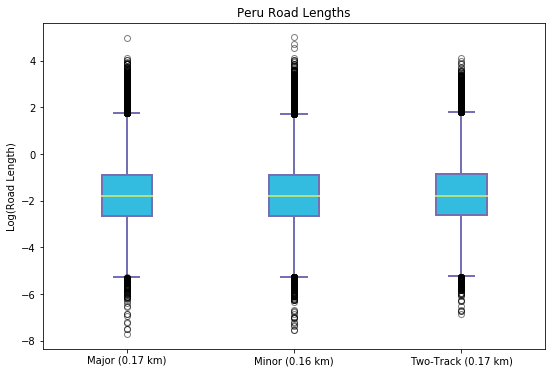

0.285209364781977
0.2778669778343462
0.3323286579021655


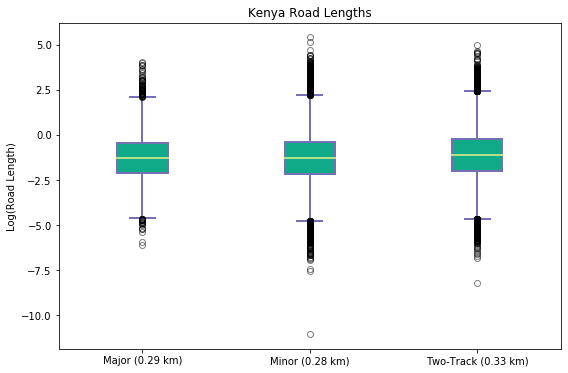

In [20]:
peru_major_lengths = np.array(peru_major_lengths)

print(np.median(peru_major_lengths))

peru_minor_lengths = np.array(peru_minor_lengths)

print(np.median(peru_minor_lengths))

peru_two_lengths = np.array(peru_two_lengths)

print(np.median(peru_two_lengths))

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot([np.log(peru_major_lengths), np.log(peru_minor_lengths), np.log(peru_two_lengths)], patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#33bbe0' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
ax.set_ylabel('Log(Road Length)')
ax.set_xticklabels(['Major (0.17 km)', 'Minor (0.16 km)', 'Two-Track (0.17 km)'])

ax.set_title('Peru Road Lengths')

plt.show()

kenya_major_lengths = np.array(kenya_major_lengths)

print(np.median(kenya_major_lengths))

kenya_minor_lengths = np.array(kenya_minor_lengths)

print(np.median(kenya_minor_lengths))

kenya_two_lengths = np.array(kenya_two_lengths)

print(np.median(kenya_two_lengths))

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot([np.log(kenya_major_lengths), np.log(kenya_minor_lengths), np.log(kenya_two_lengths)], patch_artist=True)
## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#11aa88' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
ax.set_ylabel('Log(Road Length)')
ax.set_xticklabels(['Major (0.29 km)', 'Minor (0.28 km)', 'Two-Track (0.33 km)'])

ax.set_title('Kenya Road Lengths')
plt.show()

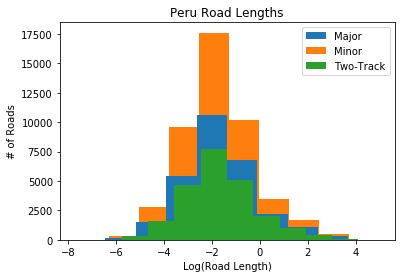

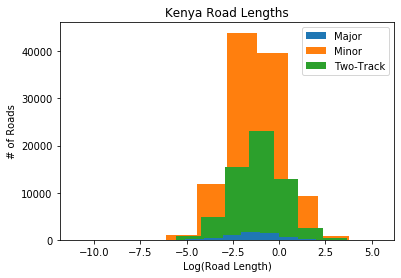

In [66]:
plt.hist(np.log(peru_major_lengths), zorder=2)
plt.hist(np.log(peru_minor_lengths), zorder=1)
plt.hist(np.log(peru_two_lengths), zorder=3)

plt.title("Peru Road Lengths")
plt.ylabel("# of Roads")
plt.xlabel("Log(Road Length)")

plt.legend(('Major', 'Minor', 'Two-Track'))

plt.show()

plt.hist(np.log(kenya_major_lengths), zorder=3)
plt.hist(np.log(kenya_minor_lengths), zorder=1)
plt.hist(np.log(kenya_two_lengths), zorder=2)

plt.title("Kenya Road Lengths")
plt.ylabel("# of Roads")
plt.xlabel("Log(Road Length)")

plt.legend(('Major', 'Minor', 'Two-Track'))

plt.show()

In [46]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D

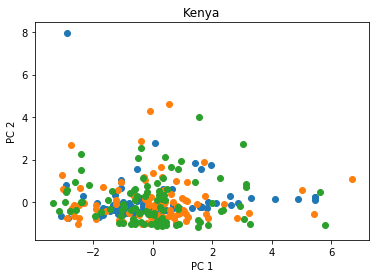

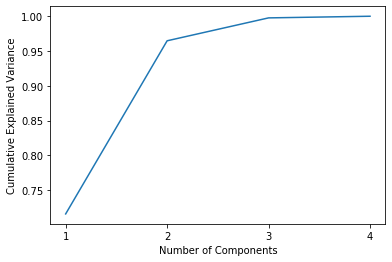

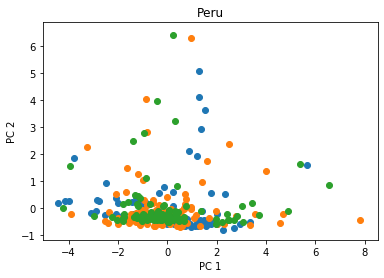

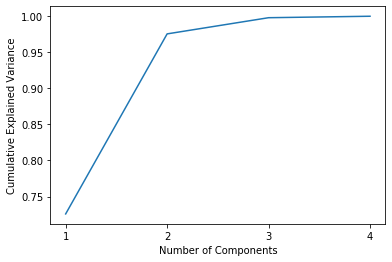

In [67]:
pca = PCA(4)

pca = pca.fit(np.concatenate((preprocessing.scale(k_major_arr), preprocessing.scale(k_minor_arr), preprocessing.scale(k_two_arr))))

k_major_projected = pca.fit_transform(preprocessing.scale(k_major_arr))
k_minor_projected = pca.fit_transform(preprocessing.scale(k_minor_arr))
k_two_projected = pca.fit_transform(preprocessing.scale(k_two_arr))

plt.scatter(k_major_projected[:, 0], k_major_projected[:, 1])
plt.scatter(k_minor_projected[:, 0], k_minor_projected[:, 1])
plt.scatter(k_two_projected[:, 0], k_two_projected[:, 1])

plt.title('Kenya')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.show()

plt.plot([1, 2, 3, 4], np.cumsum(pca.explained_variance_ratio_))
plt.xticks([1,2,3,4])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

pca = PCA(4)
pca = pca.fit(np.concatenate((preprocessing.scale(p_major_arr), preprocessing.scale(p_minor_arr), preprocessing.scale(p_two_arr))))

p_major_projected = pca.fit_transform(preprocessing.scale(p_major_arr))
p_minor_projected = pca.fit_transform(preprocessing.scale(p_minor_arr))
p_two_projected = pca.fit_transform(preprocessing.scale(p_two_arr))

plt.scatter(p_major_projected[:, 0], p_major_projected[:, 1])
plt.scatter(p_minor_projected[:, 0], p_minor_projected[:, 1])
plt.scatter(p_two_projected[:, 0], p_two_projected[:, 1])

plt.title('Peru')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.show()

plt.plot([1, 2, 3, 4], np.cumsum(pca.explained_variance_ratio_))
plt.xticks([1,2,3,4])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

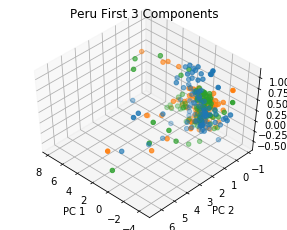

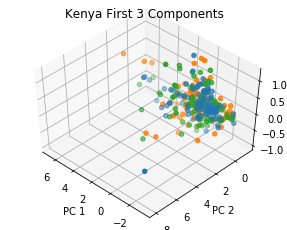

In [68]:
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(p_major_projected[:, 0], p_major_projected[:, 1], p_major_projected[:, 2])
ax.scatter(p_minor_projected[:, 0], p_minor_projected[:, 1], p_minor_projected[:, 2])
ax.scatter(p_two_projected[:, 0], p_two_projected[:, 1], p_two_projected[:, 2])

ax.set_title('Peru First 3 Components')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

plt.show()

fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(k_major_projected[:, 0], k_major_projected[:, 1], k_major_projected[:, 2])
ax.scatter(k_minor_projected[:, 0], k_minor_projected[:, 1], k_minor_projected[:, 2])
ax.scatter(k_two_projected[:, 0], k_two_projected[:, 1], k_two_projected[:, 2])

ax.set_title('Kenya First 3 Components')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

plt.show()

In [30]:
i = 5700
count=0
while True:
    if i in kenya_id_dict and kenya_dict[kenya_id_dict[i]]['roadtype'] == 'minor':
        count+=1
        print(i)
    elif count > 10:
        break
    i+=4321
print(i)
# kenya_id_dict[422246.0]
# kenya_dict[422246.0]

10021
27305
40268
66194
74836
87799
122367
126688
187182
191503
195824
200145
